In [2]:
import pandas as pd
import numpy as np
import keras
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
import random
import pickle
from keras import models, layers, callbacks
import shutil
import cv2
from math import sqrt, floor
from prettytable import PrettyTable

In [3]:
path='/home/mike/Documents/classification/Classification'

In [4]:
def print_bold(text):
    print('\033[1m{}\033[0m'.format(text))

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        
        dir_name= '{}{}/'.format(indent, os.path.basename(root))
        if dir_name.strip().startswith('.'):
            continue
        
        print_bold('\n'+dir_name)
            
        subindent = ' ' * 4 * (level + 1)
        if level==0:
            for f in files:
                if f.startswith('.'):
                    continue
                print('{}{}'.format(subindent, f))
        else:
            #if len(files)>0:
            #   print('{}File Count: {}'.format(subindent, len(files)))
            for i, f in enumerate(files):
                print('{}{}'.format(subindent, f))
                if i==2:
                    print('{}{}'.format(subindent, '...'))
                    break

list_files(path)


Classification/

    train/

        Shepherds Purse/
            b3e5c949e.png
            33010c8cb.png
            77686f343.png
            ...

        Black-grass/
            ab479d343.png
            082314602.png
            775735fb9.png
            ...

        Scentless Mayweed/
            05ceff7d1.png
            b0e6ba84f.png
            d30507567.png
            ...

        Maize/
            280c7b4d2.png
            bb9f796ce.png
            7446f241c.png
            ...

        Cleavers/
            0ac327873.png
            c0c1567ab.png
            d99ddf94b.png
            ...

        Sugar beet/
            f506aa640.png
            4eb03def0.png
            56a7b34cf.png
            ...

        Small-flowered Cranesbill/
            e909c5348.png
            b5454be5c.png
            5a2274460.png
            ...

        Common wheat/
            78e98a1ea.png
            0ff464e3e.png
            6d428b06d.png
            ...

        Loose Silky-bent/
 

In [5]:
train_ = os.path.join(path,'train')

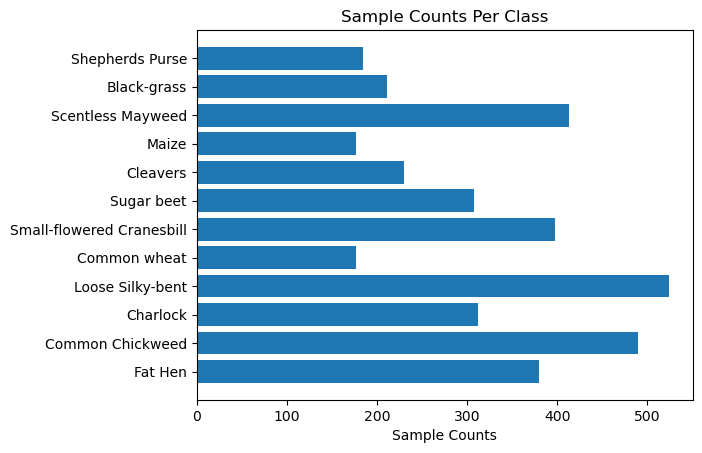

In [6]:
classes= []
sample_counts= []

for f in os.listdir(train_):
    train_class_path= os.path.join(train_, f)
    if os.path.isdir(train_class_path):
        classes.append(f)
        sample_counts.append(len(os.listdir(train_class_path)))

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(len(classes))

ax.barh(y_pos, sample_counts, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(classes)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Sample Counts')
ax.set_title('Sample Counts Per Class')

plt.show()

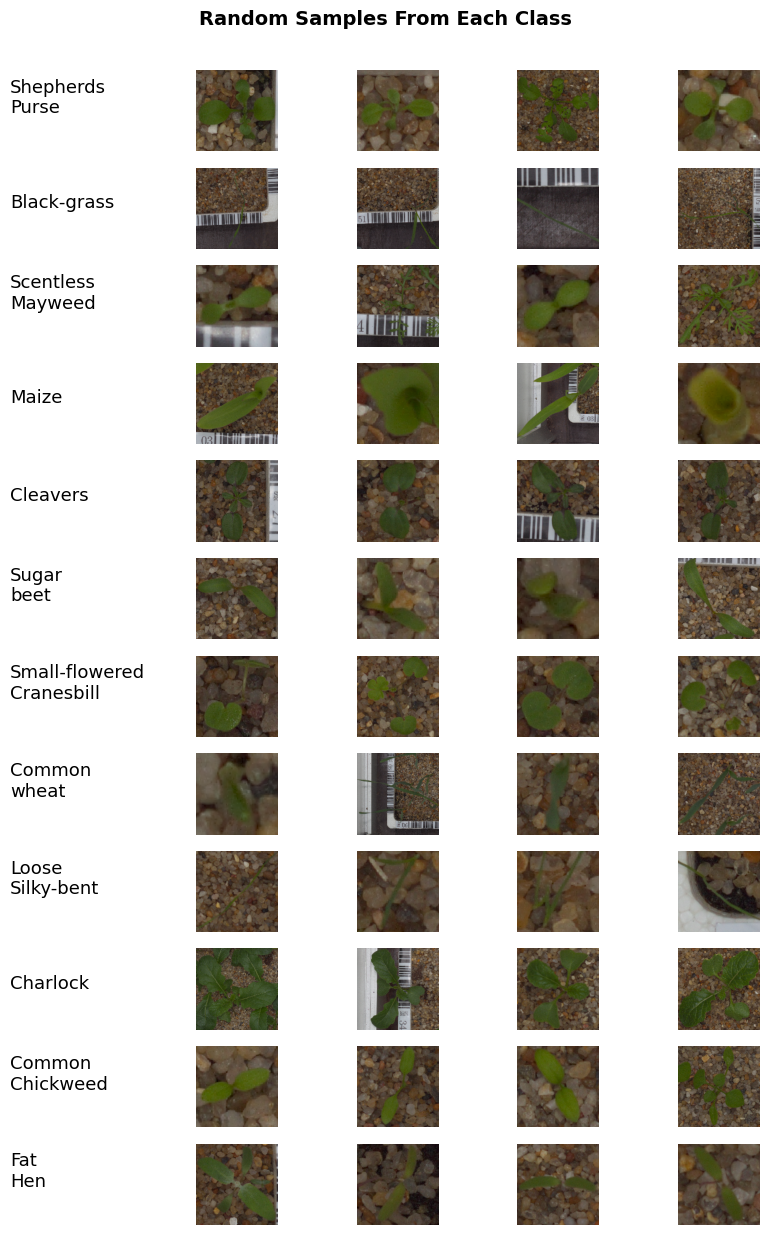

In [7]:
fig= plt.figure(figsize= (10, 15))
fig.suptitle('Random Samples From Each Class', fontsize=14, y=.92, horizontalalignment='center', weight='bold')
from tensorflow.keras.preprocessing import image
columns = 5
rows = 12
for i in range(12):
    sample_class= os.path.join(train_,classes[i])
    for j in range(1,6):
        fig.add_subplot(rows, columns, i*5+j)
        plt.axis('off')
        if j==1:
            plt.text(0.0, 0.5,str(classes[i]).replace(' ','\n'), fontsize=13, wrap=True)
            continue
        random_image= os.path.join(sample_class, random.choice(os.listdir(sample_class)))
        #from keras.preprocessing.image
        img = image.load_img(random_image, target_size=(150, 150))
        img= image.img_to_array(img)
        img/=255.
        plt.imshow(img)
        
        

plt.show()


In [9]:
#create validation set
validation_ = os.path.join(path, 'validation')
def create_validation(validation_split=0.2):    
    os.mkdir(validation_)
    for f in os.listdir(train_):
        train_class_path= os.path.join(train_, f)
        if os.path.isdir(train_class_path):
            validation_class_path= os.path.join(validation_, f)
            os.mkdir(validation_class_path)
            files_to_move= int(0.2*len(os.listdir(train_class_path)))
            
            for i in range(files_to_move):
                random_image= os.path.join(train_class_path, random.choice(os.listdir(train_class_path)))
                shutil.move(random_image, validation_class_path)
    print('Validation set created successfully using {:.2%} of training data'.format(validation_split))
                


create_validation()

Validation set created successfully using 20.00% of training data


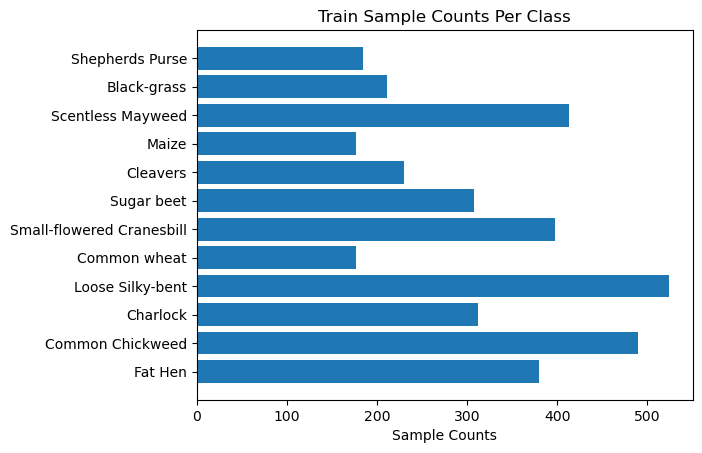

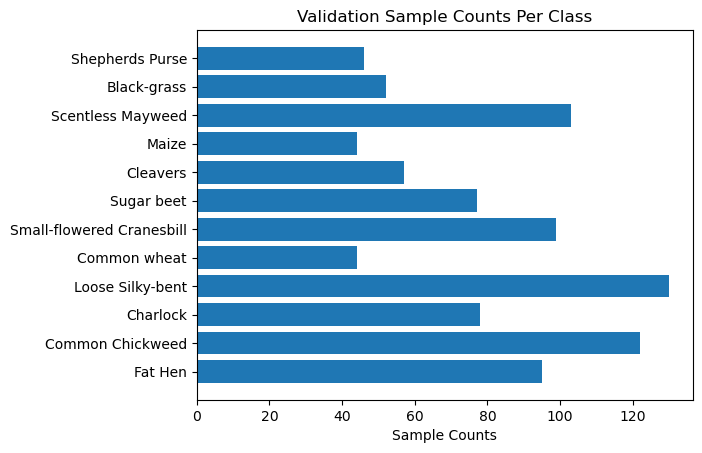

In [10]:
sample_counts= {}

for i, d in enumerate(['train', 'validation']):

    classes= []
    sample_counts[d]= []

    for f in os.listdir(os.path.join(path,d)):
        train_class_path= os.path.join(os.path.join(path,d), f)
        if os.path.isdir(train_class_path):
            classes.append(f)
            sample_counts[d].append(len(os.listdir(train_class_path)))

    #fig, ax= plt.subplot(221+i)
    fig, ax = plt.subplots()

    # Example data
    y_pos = np.arange(len(classes))

    ax.barh(y_pos, sample_counts[d], align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(classes)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Sample Counts')
    ax.set_title('{} Sample Counts Per Class'.format(d.capitalize()))

plt.show()

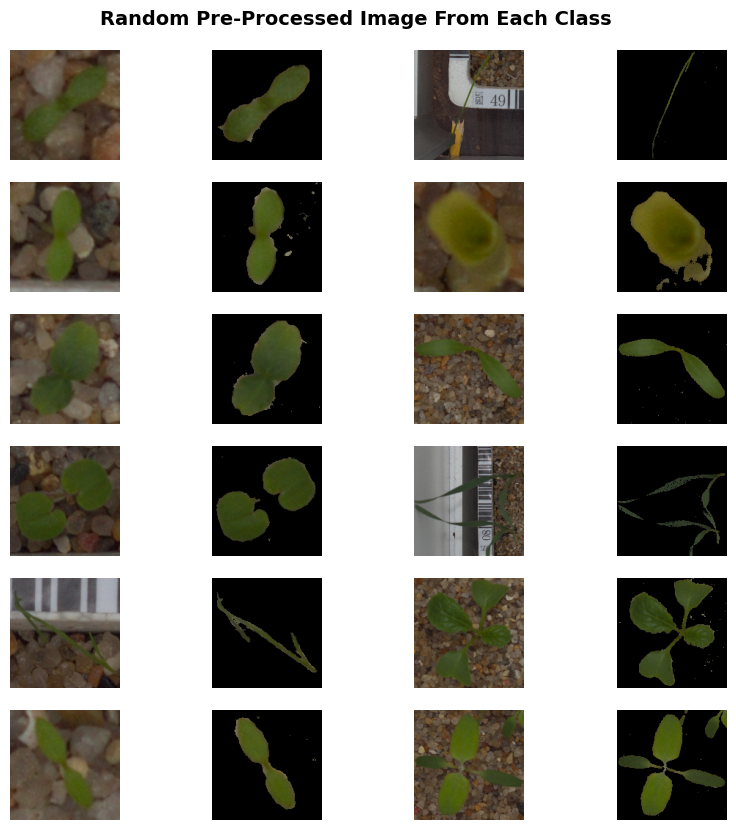

In [11]:
lower_bound= (24, 50, 0)
upper_bound= (55, 255, 255)

fig= plt.figure(figsize=(10, 10))
fig.suptitle('Random Pre-Processed Image From Each Class', fontsize=14, y=.92, horizontalalignment='center', weight='bold')

for i in range(12):
    sample_class=os.path.join(train_,classes[i])
    random_image= os.path.join(sample_class, random.choice(os.listdir(sample_class)))
    img= cv2.imread(random_image)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img= cv2.resize(img, (150, 150))
    
    hsv_img= cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv_img, lower_bound, upper_bound)
    result = cv2.bitwise_and(img, img, mask=mask)

    fig.add_subplot(6, 4, i*2+1)
    plt.imshow(img)
    plt.axis('off')    

    fig.add_subplot(6, 4, i*2+2)
    plt.imshow(result)
    plt.axis('off')
    
plt.show()


In [12]:
def color_segment_function(img_array):
    img_array= np.rint(img_array)
    img_array= img_array.astype('uint8')
    hsv_img= cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv_img, (24, 50, 0), (55, 255, 255))
    result = cv2.bitwise_and(img_array, img_array, mask=mask)
    result= result.astype('float64')
    return result


In [13]:
#image function from keras.preprocessing
train_datagen = image.ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.0,
      height_shift_range=0.0,
      shear_range=0.0,
      zoom_range=0.0,
      horizontal_flip=True,
      vertical_flip= True,
    preprocessing_function=color_segment_function,
      fill_mode='nearest')

test_datagen = image.ImageDataGenerator(rescale=1./255, preprocessing_function=color_segment_function)

In [14]:
train_generator = train_datagen.flow_from_directory(
  train_,
  target_size=(150, 150),
  batch_size=20,
  class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


In [15]:
#get class indices and labels. calculate class weight
label_map = {}
for k, v in train_generator.class_indices.items():
    label_map[v]=k

class_counts= pd.Series(train_generator.classes).value_counts()
class_weight= {}

for i, c in class_counts.items():
    class_weight[i]= 1.0/c
    
norm_factor= np.mean(list(class_weight.values()))

for k in class_counts.keys():
    class_weight[k]= class_weight[k]/norm_factor

t = PrettyTable(['class_index', 'class_label', 'class_weight'])
for i in sorted(class_weight.keys()):
    t.add_row([i, label_map[i], '{:.2f}'.format(class_weight[i])])
print(t)


+-------------+---------------------------+--------------+
| class_index |        class_label        | class_weight |
+-------------+---------------------------+--------------+
|      0      |        Black-grass        |     1.30     |
|      1      |          Charlock         |     0.88     |
|      2      |          Cleavers         |     1.19     |
|      3      |      Common Chickweed     |     0.56     |
|      4      |        Common wheat       |     1.55     |
|      5      |          Fat Hen          |     0.72     |
|      6      |      Loose Silky-bent     |     0.52     |
|      7      |           Maize           |     1.55     |
|      8      |     Scentless Mayweed     |     0.66     |
|      9      |      Shepherds Purse      |     1.48     |
|      10     | Small-flowered Cranesbill |     0.69     |
|      11     |         Sugar beet        |     0.89     |
+-------------+---------------------------+--------------+


In [16]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))


model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))



model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))


model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))


model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))

model.add(layers.Dense(12, activation='softmax'))


2023-01-07 18:55:17.992656: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mike/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-01-07 18:55:17.992689: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-07 18:55:17.992712: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mike-VirtualBox): /proc/driver/nvidia/version does not exist
2023-01-07 18:55:17.992975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate comp

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 64)        0

In [20]:
best_cb= callbacks.ModelCheckpoint('modelGenGroup1.h5', 
                                         monitor='val_loss', 
                                         verbose=1, 
                                         save_best_only=True, 
                                         save_weights_only=False, 
                                         mode='auto', 
                                         save_freq=1)

opt= keras.optimizers.Adam(learning_rate=0.0005, amsgrad=True)

In [19]:
model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(
                    train_generator,
                    class_weight= class_weight,
                    steps_per_epoch= 190,
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps= 48,
                    verbose=1,
                    use_multiprocessing=True,
                    callbacks= [best_cb])

Epoch 1/50
190/190 [==============================] - ETA: 0s - loss: 1.8065 - accuracy: 0.2480
Epoch 1: val_loss improved from inf to 1.76776, saving model to modelGenGroup1.h5
190/190 [==============================] - 131s 682ms/step - loss: 1.8065 - accuracy: 0.2480 - val_loss: 1.7678 - val_accuracy: 0.3569
Epoch 2/50
190/190 [==============================] - ETA: 0s - loss: 1.5051 - accuracy: 0.3563
Epoch 2: val_loss improved from 1.76776 to 1.58229, saving model to modelGenGroup1.h5
190/190 [==============================] - 125s 651ms/step - loss: 1.5051 - accuracy: 0.3563 - val_loss: 1.5823 - val_accuracy: 0.4541
Epoch 3/50
190/190 [==============================] - ETA: 0s - loss: 1.1566 - accuracy: 0.5089
Epoch 3: val_loss improved from 1.58229 to 0.96150, saving model to modelGenGroup1.h5
190/190 [==============================] - 122s 636ms/step - loss: 1.1566 - accuracy: 0.5089 - val_loss: 0.9615 - val_accuracy: 0.6399
Epoch 4/50
190/190 [==============================] -

In [21]:
#load best model from training
model= models.load_model('modelGenGroup1.h5')

In [22]:
#save history
with open('model_history.pkl', 'wb') as f:
    pickle.dump(history, f)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......dropout_4
.........vars
......dropout_5
.........vars
......flatten
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
......max_pooling2d_2
.........vars
......max_pooling2d_3
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified          

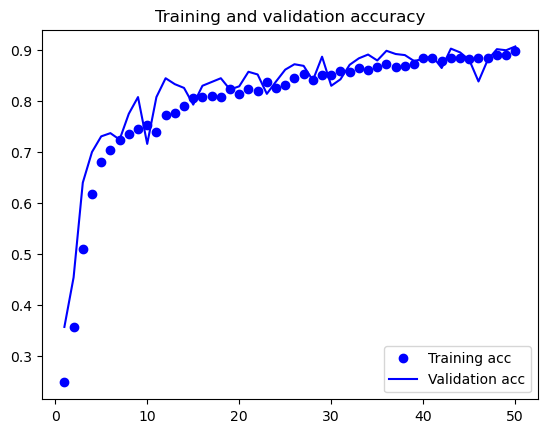

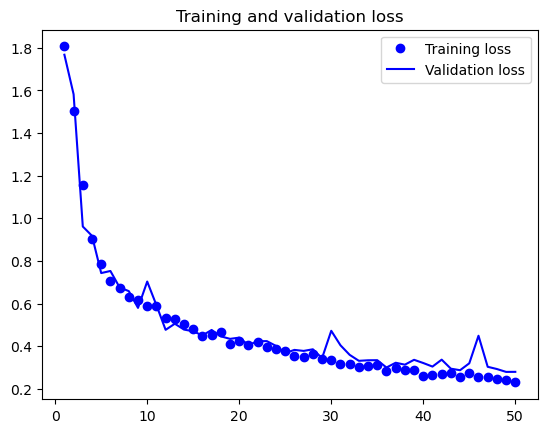

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()